In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Face Recognition Evaluation (Facenet + MTCNN)

This notebook tests face recognition accuracy using your pre-trained models on a static dataset.

---

## 🔧 Setup

In [4]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

In [6]:
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt

In [7]:
from sklearn.datasets import fetch_lfw_people

In [8]:
import os

# Load dataset
data = fetch_lfw_people(min_faces_per_person=10, resize=1.0, color=True)
images = data.images
names = data.target_names
labels = data.target

In [18]:
# Create folders
os.makedirs("/content/drive/MyDrive/Uni/Computer Vision/BTLon/images", exist_ok=True)
os.makedirs("/content/drive/MyDrive/Uni/Computer Vision/BTLon/test_faces", exist_ok=True)


FileNotFoundError: [Errno 2] No such file or directory: 'image/Jacques_Chirac.jpg'

In [9]:
# Save one known image and one test image per person
used = set()
image_dir = "/content/drive/MyDrive/Uni/Computer Vision/BTLon/images"
test_dir = "/content/drive/MyDrive/Uni/Computer Vision/BTLon/test_faces"

for i in range(len(images)):
    name = names[labels[i]].replace(" ", "_")
    img = Image.fromarray((images[i] * 255).astype(np.uint8)).convert("RGB")
    if name not in used:
        img.save(f"{image_dir}/{name}.jpg")
        used.add(name)
    else:
        img.save(f"{test_dir}/{name}_test.jpg")

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=20, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
## 📂 Load Known Faces (Gallery Set)

In [11]:
def get_embedding(img):
    face = mtcnn(img)
    if face is None:
        return None
    face = face.unsqueeze(0).to(device)
    with torch.no_grad():
        emb = resnet(face).cpu().numpy()[0]
    return emb

def load_known_faces(folder=image_dir):
    known = {}
    for path in Path(folder).glob("*.jpg"):
        img = Image.open(path).convert('RGB')
        emb = get_embedding(img)
        if emb is not None:
            known[path.stem] = emb
    return known

known_faces = load_known_faces()
known_names = list(known_faces.keys())
known_embs = torch.tensor(np.stack(list(known_faces.values()))).to(device)

In [ ]:
## 🧪 Load Test Faces

In [12]:
test_dir = Path(test_dir)  # change if needed
test_results = []

for test_path in test_dir.glob("*.jpg"):
    true_label = test_path.stem.split("_")[0]
    img = Image.open(test_path).convert("RGB")
    emb = get_embedding(img)
    if emb is None:
        continue

    emb_tensor = torch.tensor(emb).to(device)
    dists = torch.norm(known_embs - emb_tensor, dim=1)
    min_dist, min_idx = torch.min(dists, 0)

    pred_label = known_names[min_idx] if min_dist < 0.8 else "Unknown"
    test_results.append((true_label, pred_label, min_dist.item(), test_path))

In [ ]:
## 🎯 Accuracy and Examples

In [13]:
correct = sum(1 for true, pred, _, _ in test_results if true in pred)
total = len(test_results)
accuracy = correct / total if total > 0 else 0
print(f"Accuracy: {accuracy:.2%} ({correct}/{total})")

Accuracy: 67.95% (106/156)


In [ ]:
## 🖼️ Visualize Predictions

In [26]:
cols = 3
rows = (len(test_results) + cols - 1) // cols
plt.figure(figsize=(15, rows * 4))

for idx, (true, pred, dist, img_path) in enumerate(test_results):
    img = Image.open(img_path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(f"True: {true}\nPred: {pred}\nDist: {dist:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

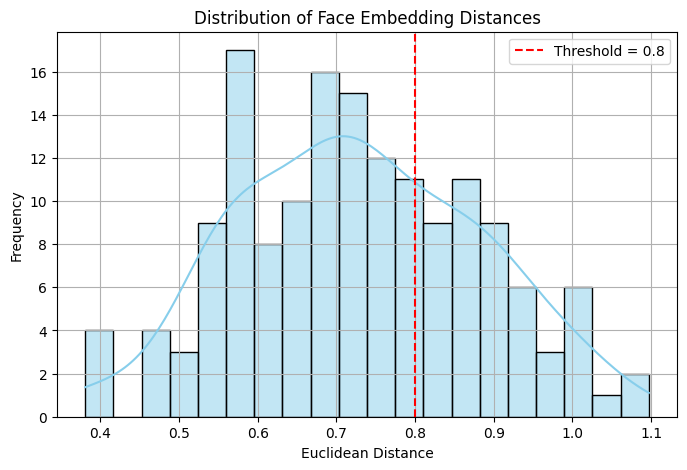

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract distances from your test_results
distances = [dist for _, _, dist, _ in test_results]

# Plot the histogram
plt.figure(figsize=(8, 5))
sns.histplot(distances, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=0.8, color='red', linestyle='--', label='Threshold = 0.8')
plt.title("Distribution of Face Embedding Distances")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()